In [14]:
# import pandas and gurobi
import pandas as pd
from gurobipy import *
import numpy as np


In [44]:
# read in csv
r = pd.read_csv("/Users/zachwayne/Documents/GitHub/15093-project/2019_monthly_data/monthly_returns_2019.csv")
s = pd.read_csv("/Users/zachwayne/Documents/GitHub/15093-project/2019_monthly_data/sectors_2019.csv")
p = pd.read_csv("/Users/zachwayne/Documents/GitHub/15093-project/2019_monthly_data/monthly_prices_2019.csv")
cor = pd.read_csv("/Users/zachwayne/Documents/GitHub/15093-project/2019_monthly_data/corr_2019.csv")
cov = pd.read_csv("/Users/zachwayne/Documents/GitHub/15093-project/2019_monthly_data/cov_2019.csv")
cov = cov.drop(columns=['Unnamed: 0'])
s = s.drop(columns=['Symbol'])
p = p.drop(columns=['Date'])
r = r.drop(columns=['Date'])
cor = cor.drop(columns=['Unnamed: 0'])

In [45]:
# make model
stocks = len(s)
k = 20
T = 12
# total = array of size 12
total = np.zeros(T)
total[0] = 300000
portfolio = np.zeros((stocks, T))
obj = np.zeros(T)
obj2 = np.zeros(T)

In [46]:
for t in range(T-1): 
    m = Model('portfolio')

    # Add matrix variable for the stocks
    x = m.addMVar(stocks)
    z = m.addVars(stocks, vtype=GRB.BINARY, name="z")
    b = m.addVars(stocks, vtype=GRB.INTEGER, lb=0, name="x")

    # Objective is to minimize risk (squared).  This is modeled using the
    # covariance matrix, which measures the historical correlation between stocks
    portfolio_risk = x @ np.matrix(cov) @ x
    ret = np.matrix(r.iloc[t+1]) @ x
    m.setObjective(portfolio_risk - ret, GRB.MINIMIZE)

    # Fix budget with a constraint
    m.addConstr(x.sum() == 1, 'budget')
    # return is at least 0.1
    m.addConstr(portfolio_risk <= 0.001, 'return')
    m.addConstrs((x[i] <= z[i] for i in range(stocks)), "w<=z")
    m.addConstrs((100*x[i] >= z[i] for i in range(stocks)), "w>=z")
    m.addConstr(quicksum(z[i] for i in range(stocks)) == k, "k")
    m.addConstr(quicksum(b[i]*p.iloc[t,i] for i in range(stocks)) <= total[t], "budget")
    m.addConstrs((b[i] >= z[i] for i in range(stocks)), "x>=fvfav")
    m.addConstrs((x[i] == (b[i]*p.iloc[t,i])/total[t] for i in range(stocks)), "w")
    m.addConstrs((quicksum(z[i]*s.iloc[i,j] for i in range(stocks)) <= 3 for j in range(len(s.columns))), "sector")
    m.Params.MIPGap = 0.01

    m.optimize()
    
    obj[t+1] = portfolio_risk.getValue()
    obj2[t+1] = ret.getValue()

    # print optimal x
    for v in m.getVars():
        if v.x > 0 and v.varName[0] == 'x':
            total[t+1] += v.x*p.iloc[t+1,int(v.varName.replace("x[","").replace("]",""))]
    portfolio[:,t] = np.array([v.x for v in m.getVars() if v.varName[0] == 'C'])

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1922 rows, 1431 columns and 5724 nonzeros
Model fingerprint: 0x9a0a0176
Model has 114003 quadratic objective terms
Model has 1 quadratic constraint
Variable types: 477 continuous, 954 integer (477 binary)
Coefficient statistics:
  Matrix range     [2e-05, 3e+03]
  QMatrix range    [1e-08, 1e-01]
  Objective range  [8e-04, 5e-01]
  QObjective range [2e-08, 2e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+05]
  QRHS range       [1e-03, 1e-03]
Presolve time: 0.10s
Presolved: 1922 rows, 1431 columns, 5724 nonzeros
Presolved model has 114003 quadratic objective terms
Presolved model has 1 quadratic constraint(s)
Variable types: 477 continuous, 954 integer (477 binary)

Root relaxation: objective -4.346624e-01, 3531 iterations, 0.18 seconds (0.43 work units)

    Nodes    |  

In [47]:
#loop through total and print out the total value of the portfolio at each time step
for i in range(len(total)):
    if i == 0:
        print("Initial value: " + str(total[i]))
    else:
        print("Total value of portfolio at the end of month " + str(i) + ": " + str(total[i]), " Risk: " + str(obj[i]), " Return: " + str(obj2[i]))

Initial value: 300000.0
Total value of portfolio at the end of month 1: 318116.8531475067  Risk: 0.001000721969331887  Return: 0.15753606640186008
Total value of portfolio at the end of month 2: 329918.6277580261  Risk: 0.0010007353097817625  Return: 0.14601187760734663
Total value of portfolio at the end of month 3: 340722.5164823532  Risk: 0.001000004462969507  Return: 0.13114793456768778
Total value of portfolio at the end of month 4: 349884.4876194  Risk: 0.0010007500448688557  Return: 0.14659010008936726
Total value of portfolio at the end of month 5: 369802.6173992157  Risk: 0.0010006463927035424  Return: 0.12614702313761691
Total value of portfolio at the end of month 6: 386221.47794914246  Risk: 0.0009956103653664659  Return: 0.14796681041354035
Total value of portfolio at the end of month 7: 397926.06965065  Risk: 0.0010008682551662109  Return: 0.1360968826447381
Total value of portfolio at the end of month 8: 404368.0676612854  Risk: 0.0009993985760170078  Return: 0.138201628

Text(0, 0.5, 'Percentage of portfolio')

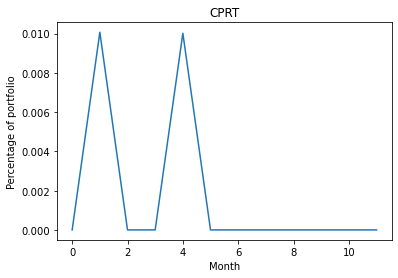

In [19]:
import matplotlib.pyplot as plt
stockPlot = 124
plt.plot(portfolio[stockPlot,:])
# TITLE  = stock name
plt.title(p.columns[stockPlot])
plt.xlabel("Month")
plt.ylabel("Percentage of portfolio")